In [49]:
import sys
from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/My Drive/Colab Notebooks/mandacaru/desafio01'
sys.path.append(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
import classification_data as cd
import matplotlib.pyplot as plt
import numpy as np
import random
from random import randint
from sklearn import metrics
from sklearn.svm import SVC
#from sklearn.svm import SVR

#### Verificar diretório do notebook

In [51]:
import sys
print('\n'.join(sys.path))


/content
/env/python
/usr/lib/python37.zip
/usr/lib/python3.7
/usr/lib/python3.7/lib-dynload
/usr/local/lib/python3.7/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.7/dist-packages/IPython/extensions
/root/.ipython
/content/drive/My Drive/mandacaru/desafio01
/content/drive/My Drive/mandacaru/desafio01
/content/drive/My Drive/mandacaru/desafio01
/content/drive/My Drive/Colab Notebooks/mandacaru/desafio01
/content/drive/My Drive/Colab Notebooks/mandacaru/desafio01
/content/drive/My Drive/Colab Notebooks/mandacaru/desafio01
/content/drive/My Drive/Colab Notebooks/mandacaru/desafio01
/content/drive/My Drive/Colab Notebooks/mandacaru/desafio01


In [52]:
import os
os.path.isdir( path +'/dataset/CNH_Aberta')

True

## Leitura da CNH

In [29]:
cnh_aberta =  cd.readpath(path + '/dataset/CNH_Aberta/*')
cnh_aberta =  cd.read_files(cnh_aberta)
cnh_aberta = cd.resize_img(cnh_aberta,(50,50))

cnh_frente =  cd.readpath(path + '/dataset/CNH_Frente/*')
cnh_frente =  cd.read_files(cnh_frente)
cnh_frente = cd.resize_img(cnh_frente,(50,50))

cnh_verso =  cd.readpath(path +  '/dataset/CNH_Verso/*')
cnh_verso =  cd.read_files(cnh_verso)
cnh_verso = cd.resize_img(cnh_verso,(50,50))

## Leitura do CPF

In [45]:
cpf_frente =  cd.readpath(path + '/dataset/CPF_Frente/*')
cpf_frente =  cd.read_files(cpf_frente)
cpf_frente = cd.resize_img(cpf_frente,(50,50))

cpf_verso =  cd.readpath(path +'/dataset/CPF_Verso/*')
cpf_verso =  cd.read_files(cpf_verso)
cpf_verso = cd.resize_img(cpf_verso,(50,50))

## Leitura do RG

In [53]:
rg_frente =  cd.readpath(path + 'dataset/RG_Frente/*')
rg_frente =  cd.read_files(rg_frente)
rg_frente = cd.resize_img(rg_frente,(50,50))

rg_verso =  cd.readpath(path + 'dataset/RG_Verso/*')
rg_verso =  cd.read_files(rg_verso)
rg_verso = cd.resize_img(rg_verso,(50,50))

rg_aberto =  cd.readpath(path + 'dataset/RG_Aberto/*')
rg_aberto =  cd.read_files(rg_aberto)
rg_aberto = cd.resize_img(rg_aberto,(50,50))

## Teste de plotagem

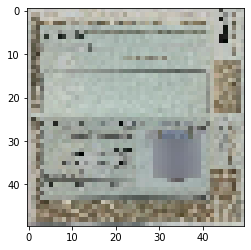

In [56]:
plt.imshow(cnh_aberta[0])
plt.show()

## Preparando os dados para o treinamento

In [42]:
labels = [1,2,3,4,5,6,7,8]
documents = []

for a,b,c,d,e,f,g,h in zip(cnh_aberta,cnh_frente,cnh_verso,cpf_frente,cpf_verso,rg_frente,rg_verso,rg_aberto):
	documents.append({'x':a, 'y':labels[0]})
	documents.append({'x':b,'y':labels[1]})
	documents.append({'x':c,'y':labels[2]})
	documents.append({'x':d,'y':labels[3]})
	documents.append({'x':e,'y':labels[4]})
	documents.append({'x':f,'y':labels[5]})
	documents.append({'x':g,'y':labels[6]})
	documents.append({'x':h,'y':labels[7]})


In [43]:
x_train = []
y_train = []

x_test = []
y_test = []

i = 0
for document in documents:
	if i < 1000:
		x_train.append(document['x'])
		y_train.append(document['y'])
	else: break

np.random.shuffle(documents[1000:]) #embaralhando os documentos

i = 0
for document in documents[1000:]:
	if i < 1000:
		x_test.append(document['x'])
		y_test.append(document['y'])
	else: break


In [ ]:
x_train, y_train = cd.started_values(x_train,y_train)
x_test, y_test = cd.started_values(x_test,y_test)

## Iniciando o treinamento usando o modelo SVC

In [ ]:
document_classifier = SVC(kernel='linear')
document_classifier.fit(x_train,y_train)

test = random.choice(documents[1000:]) #escolhendo de forma aleatória

prediction  = document_classifier.predict(test['x'].reshape(1,-1))

## Resultados do treinamento para SVC

In [ ]:
print('Score:',document_classifier.score(x_train,y_train))
print('Document:', cd.result(prediction))

plt.imshow(test['x'])
plt.show()

# Modelo de Acurácia

In [ ]:
#Vizualizacao do modelo de accuraria

#print('Accuracy:',metrics.accuracy_score(y_test[:1000],y_train[:1000]))

plt.plot(y_test[:1000])
plt.plot(y_train[:1000])
plt.title("Modelo de Acurácia:")
plt.ylabel('Acurácia')
plt.xlabel('Tempo')
plt.legend(['Treinamento', 'Valor'], loc='upper right')
plt.show()

# Modelo de Perda

In [ ]:
#Vizulizacao do modelo de perda

plt.plot(y_test[:1000])
plt.plot(y_test[:1000])
plt.title("Modelo de Perda:")
plt.ylabel('Perda')
plt.xlabel('Tempo')
plt.legend(['Treinamento', 'Valor'], loc='upper left')
plt.show()

# Rede Neural Convolucional

In [ ]:
import tensorflow as tf
import keras as K
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

## Inicializando a Rede Neural Convolucional

In [ ]:
classifier = Sequential()

### 1. Primeira Camada de Convolução

In [ ]:
#Convertendo todas as imagens 64x64 pixels por um array 3d (3 cores)
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))

### 2. Pooling

In [ ]:
#agrupando para diminuir o mapa das imagens
classifier.add(MaxPooling2D(pool_size = (2, 2)))

In [ ]:
# Adicionando a Segunda Camada de Convolução
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))

In [ ]:
#agrupamento na segunda camada
classifier.add(MaxPooling2D(pool_size = (2, 2)))

### 3. Flattening

In [ ]:
#tecnica do achatamento tansanformando o map em um vetor
classifier.add(Flatten())

### 4. Full connection

In [ ]:
'''
Full connection -> juntando todo mundo 
relu -> ativação retificadora
sigmoid -> probabilidade de certo de cada imagem 
'''
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

In [ ]:
#Compilando a rede
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Treinando a Rede Neural Convolucional

In [ ]:
#Loding data
from keras.datasets import cifar10
#dividindo dataset em teste e treino
(x_train,y_train), (x_test,y_test) = cifar10.load_data()
#classificação 
classification = ['airplane','autombile','bird','cat','deer','dog','frog','house','ship','truck']

In [ ]:
test_image = image.load_img(cifar10, target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
training_set.class_indices

if result[0][0] == 1:
    prediction = 'Cachorro'
else:
    prediction = 'Gato'

Image(filename='dataset_teste/2216.jpg')